# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

From a data science perspective, the goal is to develop a predictive model that accurately estimates used car prices based on a variety of features such as vehicle specifications, age, manufacturer, and condition. This involves identifying key features (predictors) that most strongly influence the target variable (car price) and building regression models to quantify these relationships. The task will involve feature selection, data transformation, and model evaluation to predict prices and provide insights into the factors that most affect the resale value of vehicles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.feature_selection import SequentialFeatureSelector

# 1 Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### 1.1 Load the data

The following code will load the data into a pandas dataframe and then provide a highlevel view of the columns and column types.
Additionally the cleanup of the data will start by transforming all characterse to lower case and removing "-".

In [2]:
vehicles_df = pd.read_csv('data/vehicles.csv', low_memory=False)
vehicles_df = vehicles_df.applymap(lambda s: s.lower() if isinstance(s, str) else s)
vehicles_df = vehicles_df.applymap(lambda x: x.replace('-', '') if isinstance(x, str) else x)
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [3]:
vehicles_df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


## 2 Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling. Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with sklearn. 

### 2.1 Cleanup

This script counts the number of rows before and after dropping rows where both manufacturer and model are missing, then outputs the number of rows dropped:

    Count initial rows.
    Drop rows where both manufacturer and model are missing.
    Count final rows.
    Print the number of rows dropped.

In [4]:
# Before dropping rows, count the number of rows
initial_row_count = len(vehicles_df)

# Drop rows where either 'model' or 'price' have missing values
vehicles_df = vehicles_df.dropna(subset=['manufacturer', 'model'], how='all')

# After dropping rows, count the number of rows
final_row_count = len(vehicles_df)

# Calculate how many rows were dropped
rows_dropped = initial_row_count - final_row_count

# Output the result
print(f"Number of rows dropped: {rows_dropped}")

Number of rows dropped: 69


### 2.2 Cleanup
Remove descriptive words from the model feature

In [5]:
words_to_remove = ['sedan', 'coupe', '2d', '4d', 'suv', '4x4','extended','cab', 'grand','sport','430i','gran','momentum','350','xlt']

# Create a regex pattern to match any of the words
pattern = r'\b(?:' + '|'.join(words_to_remove) + r')\b'

# Replace the words in the 'model' column
vehicles_df['model'] = vehicles_df['model'].str.replace(pattern, '', regex=True)

# Clean up any extra whitespace
vehicles_df['model'] = vehicles_df['model'].str.replace(r'\s+', ' ', regex=True).str.strip()

### 2.3 Cleanup
Check VIN column for duplicates

In [6]:
# Normalize the VIN column: trim spaces, convert to uppercase
vehicles_df['VIN'] = vehicles_df['VIN'].str.strip().str.upper()

# Filter out invalid VINs (NaN, 'other', '0', or less than 10 characters)
valid_vin_df = vehicles_df[
    vehicles_df['VIN'].notna() & 
    (vehicles_df['VIN'] != 'OTHER') & 
    (vehicles_df['VIN'] != '0') & 
    (vehicles_df['VIN'].str.len() > 10)
]

# Identify duplicated VINs
duplicated_vins = valid_vin_df[valid_vin_df.duplicated(subset=['VIN'], keep=False)]

# Group by VIN and count how many times each is duplicated
vin_counts = duplicated_vins.groupby('VIN').size().reset_index(name='count')

# Filter to show only duplicated VINs
duplicated_vin_counts = vin_counts[vin_counts['count'] > 1]

# Show an example of 10 VINs and how many times they are duplicated
print("Example of 10 duplicated VINs and their counts:")
print(duplicated_vin_counts.head(10))

# Display the number of real duplicated VINs
total_duplicated_vins = duplicated_vin_counts.shape[0]
print(f"\nTotal number of real duplicated VINs: {total_duplicated_vins}")


Example of 10 duplicated VINs and their counts:
                 VIN  count
0  0000000RN47028886      3
1  0000000T05H107426      2
2  0000000V264204442      2
3  0000004Y83Z146570      2
4  000000ECR33107314      2
5   000000F1BH525035      2
6  000000VC55J202641     10
7  00000HDJ810018347     29
8  00000ST2050009277      2
9  0000136807Z137048      3

Total number of real duplicated VINs: 40215


### 2.4 Create Dictionary of Feature for replacing missing data later on

In [7]:
# Initialize an empty dictionary to store model-based information
missing_data = {}

# Iterate through each row in the DataFrame
for _, row in vehicles_df.iterrows():
    model = row['model']
    
    # Skip rows with NaN models
    if pd.isna(model):
        continue
    
    # Collect non-NaN, non-"other", non-"unknown" values
    manufacturer = row['manufacturer'] if pd.notna(row['manufacturer']) and row['manufacturer'] not in ['other', 'unknown'] else None
    cylinders = row['cylinders'] if pd.notna(row['cylinders']) and row['cylinders'] not in ['other', 'unknown'] else None
    fuel = row['fuel'] if pd.notna(row['fuel']) and row['fuel'] not in ['other', 'unknown'] else None
    transmission = row['transmission'] if pd.notna(row['transmission']) and row['transmission'] not in ['other', 'unknown'] else None
    drive = row['drive'] if pd.notna(row['drive']) and row['drive'] not in ['other', 'unknown'] else None
    size = row['size'] if pd.notna(row['size']) and row['size'] not in ['other', 'unknown'] else None

    # Only create an entry if the model isn't already in the dictionary
    if model not in missing_data:
        missing_data[model] = {
            'manufacturer': manufacturer,
            'cylinders': cylinders,
            'fuel': fuel,
            'transmission': transmission,
            'drive': drive,
            'size': size
        }

# Remove keys with None values from the dictionary
for model, data in missing_data.items():
    missing_data[model] = {k: v for k, v in data.items() if v is not None}

# Print a sample of the dictionary (e.g., first 10 entries)
sample_data = {k: missing_data[k] for k in list(missing_data)[:10]}
print(sample_data)

{'sierra 1500 crew slt': {'manufacturer': 'gmc', 'cylinders': '8 cylinders', 'fuel': 'gas'}, 'silverado 1500': {'manufacturer': 'chevrolet', 'cylinders': '8 cylinders', 'fuel': 'gas'}, 'silverado 1500 crew': {'manufacturer': 'chevrolet', 'cylinders': '8 cylinders', 'fuel': 'gas'}, 'tundra double sr': {'manufacturer': 'toyota', 'cylinders': '8 cylinders', 'fuel': 'gas'}, 'f150': {'manufacturer': 'ford', 'cylinders': '6 cylinders', 'fuel': 'gas', 'transmission': 'automatic', 'drive': 'rwd', 'size': 'fullsize'}, 'sierra 2500 hd': {'manufacturer': 'gmc', 'cylinders': '8 cylinders', 'fuel': 'gas', 'drive': '4wd'}, 'silverado 1500 double': {'manufacturer': 'chevrolet', 'cylinders': '6 cylinders', 'fuel': 'gas', 'drive': '4wd'}, 'tacoma': {'manufacturer': 'toyota', 'cylinders': '6 cylinders', 'fuel': 'gas', 'transmission': 'automatic', 'drive': '4wd'}, 'colorado': {'manufacturer': 'chevrolet', 'cylinders': '6 cylinders', 'fuel': 'gas', 'drive': '4wd'}, 'corvette': {'manufacturer': 'chevrolet'

### 2.5 Remove Duplicate VINS

In [8]:
# Drop rows where VIN is duplicated, keeping only the first occurrence
deduplicated_df = valid_vin_df.drop_duplicates(subset=['VIN'], keep='first')

# Drop the VIN column
deduplicated_df = deduplicated_df.drop(columns=['VIN'])

# Display the result
print("\nDataFrame after dropping duplicated VIN rows and the VIN column:")
print(deduplicated_df.head())



DataFrame after dropping duplicated VIN rows and the VIN column:
            id  region  price    year manufacturer                 model  \
27  7316814884  auburn  33590  2014.0          gmc  sierra 1500 crew slt   
28  7316814758  auburn  22590  2010.0    chevrolet        silverado 1500   
29  7316814989  auburn  39590  2020.0    chevrolet   silverado 1500 crew   
30  7316743432  auburn  30990  2017.0       toyota      tundra double sr   
32  7316343444  auburn  27990  2012.0          gmc        sierra 2500 hd   

   condition    cylinders fuel  odometer title_status transmission drive size  \
27      good  8 cylinders  gas   57923.0        clean        other   NaN  NaN   
28      good  8 cylinders  gas   71229.0        clean        other   NaN  NaN   
29      good  8 cylinders  gas   19160.0        clean        other   NaN  NaN   
30      good  8 cylinders  gas   41124.0        clean        other   NaN  NaN   
32      good  8 cylinders  gas   68696.0        clean        other   4wd

In [9]:
vehicles_df = deduplicated_df
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117762 entries, 27 to 426833
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            117762 non-null  int64  
 1   region        117762 non-null  object 
 2   price         117762 non-null  int64  
 3   year          117177 non-null  float64
 4   manufacturer  114774 non-null  object 
 5   model         117077 non-null  object 
 6   condition     60799 non-null   object 
 7   cylinders     69946 non-null   object 
 8   fuel          116176 non-null  object 
 9   odometer      116190 non-null  float64
 10  title_status  114169 non-null  object 
 11  transmission  116576 non-null  object 
 12  drive         90613 non-null   object 
 13  size          30109 non-null   object 
 14  type          101766 non-null  object 
 15  paint_color   87263 non-null   object 
 16  state         117762 non-null  object 
dtypes: float64(2), int64(2), object(13)
memory usage: 16

### 2.6 Check for Missing Values per Column

In [10]:
# Calculate the percentage of missing values in each column
missing_percentage = vehicles_df.isnull().mean() * 100

# Create a DataFrame directly from the missing_percentage Series
missing_data_df = pd.DataFrame({
    'Column': missing_percentage.index,
    'Percentage Missing': missing_percentage.values
}).sort_values(by='Percentage Missing', ascending=False)

# Display the missing data percentage for each column
print(missing_data_df)


          Column  Percentage Missing
13          size           74.432330
6      condition           48.371291
7      cylinders           40.603930
15   paint_color           25.898847
12         drive           23.054126
14          type           13.583329
10  title_status            3.051069
4   manufacturer            2.537321
8           fuel            1.346784
9       odometer            1.334896
11  transmission            1.007116
5          model            0.581682
3           year            0.496765
0             id            0.000000
1         region            0.000000
2          price            0.000000
16         state            0.000000


### 2.7 Replace Missing Values with Data from Dictionary

In [11]:
# Function to fill missing values based on the dictionary
def fill_missing_values(row):
    model = row['model']
    
    # Skip rows with NaN models
    if pd.isna(model):
        return row
    
    # Get model-specific information from the dictionary
    model_info = missing_data.get(model, {})
    
    # Fill missing values for each relevant column
    if pd.isna(row['manufacturer']) or row['manufacturer'] in ['other', 'unknown']:
        if model_info.get('manufacturer'):
            row['manufacturer'] = model_info['manufacturer']
    
    if pd.isna(row['cylinders']) or row['cylinders'] in ['other', 'unknown']:
        if model_info.get('cylinders'):
            row['cylinders'] = model_info['cylinders']
    
    if pd.isna(row['fuel']) or row['fuel'] in ['other', 'unknown']:
        if model_info.get('fuel'):
            row['fuel'] = model_info['fuel']
    
    if pd.isna(row['transmission']) or row['transmission'] in ['other', 'unknown']:
        if model_info.get('transmission'):
            row['transmission'] = model_info['transmission']
    
    if pd.isna(row['drive']) or row['drive'] in ['other', 'unknown']:
        if model_info.get('drive'):
            row['drive'] = model_info['drive']
    
    if pd.isna(row['size']) or row['size'] in ['other', 'unknown']:
        if model_info.get('size'):
            row['size'] = model_info['size']
    
    return row

# Apply the function to the DataFrame to fill in missing values
vehicles_df = deduplicated_df.apply(fill_missing_values, axis=1)
vehicles_df

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
27,7316814884,auburn,33590,2014.0,gmc,sierra 1500 crew slt,good,8 cylinders,gas,57923.0,clean,other,NaN,NaN,pickup,white,al
28,7316814758,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,NaN,pickup,blue,al
29,7316814989,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,NaN,pickup,red,al
30,7316743432,auburn,30990,2017.0,toyota,tundra double sr,good,8 cylinders,gas,41124.0,clean,other,NaN,NaN,pickup,red,al
32,7316343444,auburn,27990,2012.0,gmc,sierra 2500 hd,good,8 cylinders,gas,68696.0,clean,other,4wd,NaN,pickup,black,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426682,7305969547,wyoming,17873,2018.0,NaN,thunder creek fuel trailer mt2,NaN,NaN,NaN,501.0,clean,NaN,NaN,NaN,other,custom,wy
426727,7305023302,wyoming,4500,2006.0,chrysler,pacifica,NaN,6 cylinders,gas,163837.0,clean,automatic,fwd,midsize,wagon,silver,wy
426737,7304360046,wyoming,2500,2005.0,honda,civic,good,4 cylinders,gas,185000.0,clean,manual,fwd,compact,sedan,grey,wy
426746,7303723154,wyoming,17950,2004.0,ford,f350 super duty,excellent,8 cylinders,diesel,186000.0,clean,automatic,4wd,NaN,other,NaN,wy


### 2.8 Check for Missing Value again

In [12]:
# Calculate the percentage of missing values in each column
missing_percentage = vehicles_df.isnull().mean() * 100

# Create a DataFrame directly from the missing_percentage Series
missing_data_df = pd.DataFrame({
    'Column': missing_percentage.index,
    'Percentage Missing': missing_percentage.values
}).sort_values(by='Percentage Missing', ascending=False)

# Display the missing data percentage for each column
print(missing_data_df)

          Column  Percentage Missing
13          size           58.559637
6      condition           48.371291
15   paint_color           25.898847
7      cylinders           17.637268
14          type           13.583329
12         drive            9.801973
10  title_status            3.051069
4   manufacturer            2.253698
9       odometer            1.334896
8           fuel            0.780388
5          model            0.581682
3           year            0.496765
11  transmission            0.174929
0             id            0.000000
1         region            0.000000
2          price            0.000000
16         state            0.000000


### 2.9 Remove ID, Size and Condition Features
These columns have to much data missing or are not required

In [13]:
vehicles_df = vehicles_df.drop(['id', 'size','condition'], axis=1)

### 2.10 Cleanup / Transformation
The code performs the following actions:

    Removes the word "cylinders" from the 'cylinders' column.
    Converts 'year' to 'age' and drops the 'year' column.
    Excludes 'harley-davidson' from the 'manufacturer' column.
    Replaces 'rover' with 'land rover' and 'mini' with 'bmw'.
    Filters out cars priced below $1000 and cars less than 3 years old.

In [14]:
# Remove the word 'cylinders' from the 'cylinders' column
vehicles_df['cylinders'] = vehicles_df['cylinders'].str.replace('cylinders', '').str.strip()

# Convert 'year' to Datetime and Calculate 'age'
vehicles_df['year'] = pd.to_datetime(vehicles_df['year'], format='%Y', errors='coerce')

# Ensure valid years are converted to integers
vehicles_df['age'] = pd.to_datetime('today').year - vehicles_df['year'].dt.year
vehicles_df = vehicles_df.drop(columns=['year'])

# Exclude 'harley-davidson' from 'manufacturer'
vehicles_df = vehicles_df[vehicles_df['manufacturer'].str.lower() != 'harleydavidson']

# Replace specific manufacturer values
vehicles_df['manufacturer'] = vehicles_df['manufacturer'].replace({'rover': 'land rover', 'mini': 'bmw'})

# Only have records of Cars over $1000
vehicles_df = vehicles_df[vehicles_df['price'] > 1000]

# Only have records of Cars over 1 years old
vehicles_df = vehicles_df[vehicles_df['age'] > 2]

### 2.11 Cleanup / Transformation

This code performs the following tasks:

    Dropping Rows with Missing Values:
        It removes rows where any of the manufacturer, model, or odometer columns have missing values.
        Then it removes rows where the price column is missing.

    Counting Missing Data:
        After each step, the code checks for any remaining missing values across all columns and filters out columns where there are missing values.

    Unique Value Counts for Several Columns:
        The code then computes and prints the unique values and their counts for the following columns:
            fuel
            title_status
            drive
            type
            paint_color
            transmission

This provides insight into the distribution of values and any potential missing data in key categorical features of the dataset.

In [15]:

vehicles_df = vehicles_df.dropna(subset=['manufacturer', 'model','odometer'], how='any')
missing_data = vehicles_df.isna().sum()
missing_columns = missing_data[missing_data > 0]

vehicles_df = vehicles_df.dropna(subset=['price'], how='all')
missing_data = vehicles_df.isna().sum()
missing_columns = missing_data[missing_data > 0]

# Unique values and counts for the 'fuel' column
fuel_counts = vehicles_df['fuel'].value_counts(dropna=False)
print("Fuel:")
print(fuel_counts)
print("\n")

# Unique values and counts for the 'title_status' column
title_status_counts = vehicles_df['title_status'].value_counts(dropna=False)
print("Title Status:")
print(title_status_counts)
print("\n")

# Unique values and counts for the 'drive' column
drive_counts = vehicles_df['drive'].value_counts(dropna=False)
print("Drive:")
print(drive_counts)
print("\n")

# Unique values and counts for the 'type' column
type_counts = vehicles_df['type'].value_counts(dropna=False)
print("Type:")
print(type_counts)
print("\n")

# Unique values and counts for the 'paint_color' column
paint_color_counts = vehicles_df['paint_color'].value_counts(dropna=False)
print("Paint Color:")
print(paint_color_counts)

# Unique values and counts for the 'transmission' column
transmission_counts = vehicles_df['transmission'].value_counts(dropna=False)
print("Transmission:")
print(transmission_counts)

Fuel:
fuel
gas         88235
diesel       4908
hybrid       1449
other        1427
NaN           813
electric      484
Name: count, dtype: int64


Title Status:
title_status
clean         92766
NaN            2502
rebuilt        1302
salvage         530
lien            193
missing          18
parts only        5
Name: count, dtype: int64


Drive:
drive
4wd    37144
fwd    35514
rwd    15574
NaN     9084
Name: count, dtype: int64


Type:
type
sedan          23867
suv            22678
NaN            12744
pickup          9065
truck           7337
other           5182
hatchback       4152
coupe           3662
wagon           3290
van             2249
convertible     1637
minivan         1340
offroad           62
bus               51
Name: count, dtype: int64


Paint Color:
paint_color
NaN       21936
white     19307
black     16360
silver    11958
blue       8005
red        7137
grey       6757
custom     1799
green      1599
brown      1464
orange      431
yellow      393
purple      170

### 2.12 Cleanup / Transformation

This code performs data cleaning on the vehicles_df DataFrame by addressing missing or ambiguous values in specific columns:

    Replacing Invalid Values with the Mode:
        For the fuel, title_status, and transmission columns, any NaN, 'other', or 'unknown' values are replaced with the most common (modal) value in that column.

    Removing Invalid Rows:
        For the drive, paint_color, type, and cylinders columns, rows that contain NaN, 'other', or 'unknown' values are removed entirely from the DataFrame.

The final DataFrame is printed with cleaned data, ensuring no ambiguous or missing values remain in the specified columns. This cleaning prepares the dataset for further analysis or modeling.

In [16]:
# Replace NaN, 'other', or 'unknown' with the modal value in 'fuel' column
fuel_mode = vehicles_df['fuel'].mode()[0]
vehicles_df['fuel'] = vehicles_df['fuel'].replace(['other', 'unknown', np.nan], fuel_mode)

# Replace NaN, 'other', or 'unknown' with the modal value in 'title_status' column
title_status_mode = vehicles_df['title_status'].mode()[0]
vehicles_df['title_status'] = vehicles_df['title_status'].replace(['other', 'unknown', np.nan], title_status_mode)

# Remove rows where 'drive' is NaN, 'other', or 'unknown'
vehicles_df = vehicles_df[~vehicles_df['drive'].isin(['other', 'unknown']) & vehicles_df['drive'].notna()]

# Remove rows where 'paint_color' is NaN, 'other', or 'unknown'
vehicles_df = vehicles_df[~vehicles_df['paint_color'].isin(['other', 'unknown']) & vehicles_df['paint_color'].notna()]

# Replace NaN, 'other', or 'unknown' with the modal value in 'transmission' column
transmission_mode = vehicles_df['transmission'].mode()[0]
vehicles_df['transmission'] = vehicles_df['transmission'].replace(['other', 'unknown', np.nan], transmission_mode)

# Remove rows where 'type' is NaN, 'other', or 'unknown'
vehicles_df = vehicles_df[~vehicles_df['type'].isin(['other', 'unknown']) & vehicles_df['type'].notna()]

# Remove rows where 'type' is NaN, 'other', or 'unknown'
vehicles_df = vehicles_df[~vehicles_df['cylinders'].isin(['other', 'unknown']) & vehicles_df['cylinders'].notna()]

# Display the updated DataFrame (optional)
print(vehicles_df.head())


    region  price manufacturer                  model cylinders fuel  \
32  auburn  27990          gmc         sierra 2500 hd         8  gas   
33  auburn  34590    chevrolet  silverado 1500 double         6  gas   
35  auburn  29990    chevrolet               colorado         6  gas   
42  auburn  37990    chevrolet              camaro ss         8  gas   
45  auburn  27990       nissan    frontier crew pro4x         6  gas   

    odometer title_status transmission drive    type paint_color state   age  
32   68696.0        clean    automatic   4wd  pickup       black    al  12.0  
33   29499.0        clean    automatic   4wd  pickup      silver    al   8.0  
35   17302.0        clean    automatic   4wd  pickup         red    al   8.0  
42    9704.0        clean    automatic   rwd   coupe         red    al   8.0  
45   37332.0        clean    automatic   4wd  pickup      silver    al   6.0  


### 2.13 Cleanup / Transformation

his code outputs the unique values and their counts for various categorical columns in the vehicles_df DataFrame, as well as the number of unique models present in the dataset.

Here's a summary of what each section of the code does:

    Fuel Counts: Displays the unique values and their counts for the fuel column.
    Title Status Counts: Displays the unique values and their counts for the title_status column.
    Drive Counts: Displays the unique values and their counts for the drive column.
    Type Counts: Displays the unique values and their counts for the type column.
    Paint Color Counts: Displays the unique values and their counts for the paint_color column.
    Transmission Counts: Displays the unique values and their counts for the transmission column.
    Model Count: Outputs the total number of unique values in the model column.

This code provides a detailed breakdown of categorical variables, helping to understand the distribution of values within each of these columns.

In [17]:
# Unique values and counts for the 'fuel' column
fuel_counts = vehicles_df['fuel'].value_counts(dropna=False)
print("Fuel:")
print(fuel_counts)
print("\n")

# Unique values and counts for the 'title_status' column
title_status_counts = vehicles_df['title_status'].value_counts(dropna=False)
print("Title Status:")
print(title_status_counts)
print("\n")

# Unique values and counts for the 'drive' column
drive_counts = vehicles_df['drive'].value_counts(dropna=False)
print("Drive:")
print(drive_counts)
print("\n")

# Unique values and counts for the 'type' column
type_counts = vehicles_df['type'].value_counts(dropna=False)
print("Type:")
print(type_counts)
print("\n")

# Unique values and counts for the 'paint_color' column
paint_color_counts = vehicles_df['paint_color'].value_counts(dropna=False)
print("Paint Color:")
print(paint_color_counts)
print("\n")


# Unique values and counts for the 'transmission' column
transmission_counts = vehicles_df['transmission'].value_counts(dropna=False)
print("Transmission:")
print(transmission_counts)
print("\n")

# Get the count of unique models in the 'model' column
model_count = vehicles_df['model'].nunique()

# Output the result
print(f"There are {model_count} unique models in the dataset.")


Fuel:
fuel
gas         50249
diesel       2586
hybrid        765
electric       53
Name: count, dtype: int64


Title Status:
title_status
clean         52073
rebuilt         994
salvage         410
lien            162
missing          10
parts only        4
Name: count, dtype: int64


Drive:
drive
4wd    22904
fwd    20896
rwd     9853
Name: count, dtype: int64


Type:
type
sedan          16038
suv            15294
pickup          6296
truck           5355
coupe           2561
hatchback       2093
wagon           1889
van             1787
convertible     1198
minivan         1042
offroad           57
bus               43
Name: count, dtype: int64


Paint Color:
paint_color
white     13096
black     11119
silver     8453
grey       5816
blue       5625
red        5012
custom     1504
green      1217
brown      1086
yellow      294
orange      292
purple      139
Name: count, dtype: int64


Transmission:
transmission
automatic    50809
manual        2844
Name: count, dtype: int64


There

### 2.14 Checking for Outliers - Age

Its clear from this graph that we have outliers on the X and Y axis

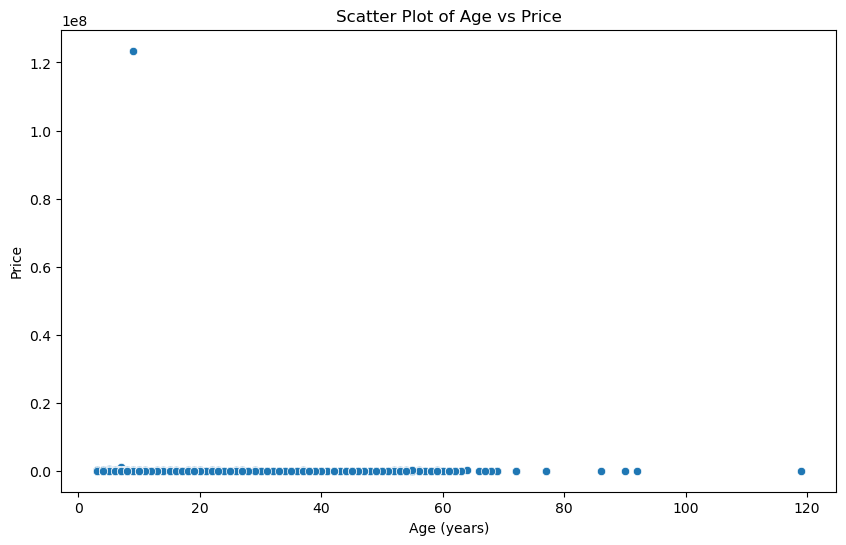

In [18]:
# Plotting Age vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=vehicles_df['age'], y=vehicles_df['price'])

# Add labels and title
plt.xlabel('Age (years)')
plt.ylabel('Price')
plt.title('Scatter Plot of Age vs Price')

# Display the plot
plt.show()

### 2.15 Checking for Outliers - Manufacturer

Its clear from this graph that we have outliers on the Y axis

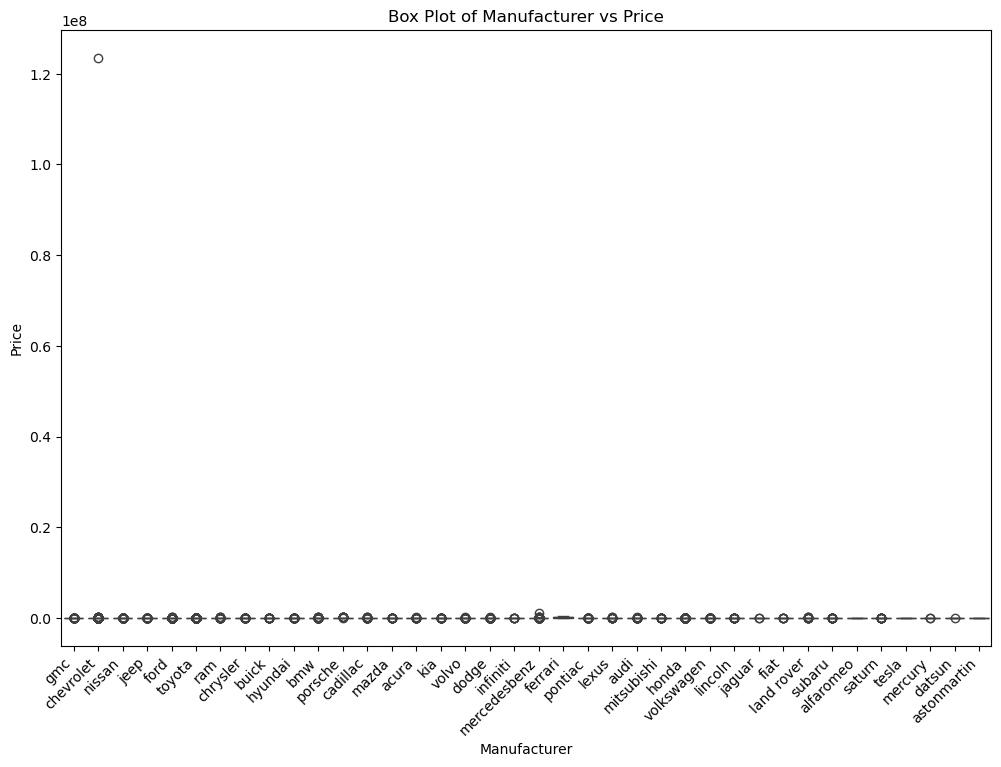

In [19]:
# Plotting Manufacturer vs. Price using a Box Plot
plt.figure(figsize=(12, 8))
sns.boxplot(x=vehicles_df['manufacturer'], y=vehicles_df['price'])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Manufacturer')
plt.ylabel('Price')
plt.title('Box Plot of Manufacturer vs Price')

# Display the plot
plt.show()


### 2.16 Checking for Outliers - Odometer

Its clear from this graph that we have outliers on the Y axis

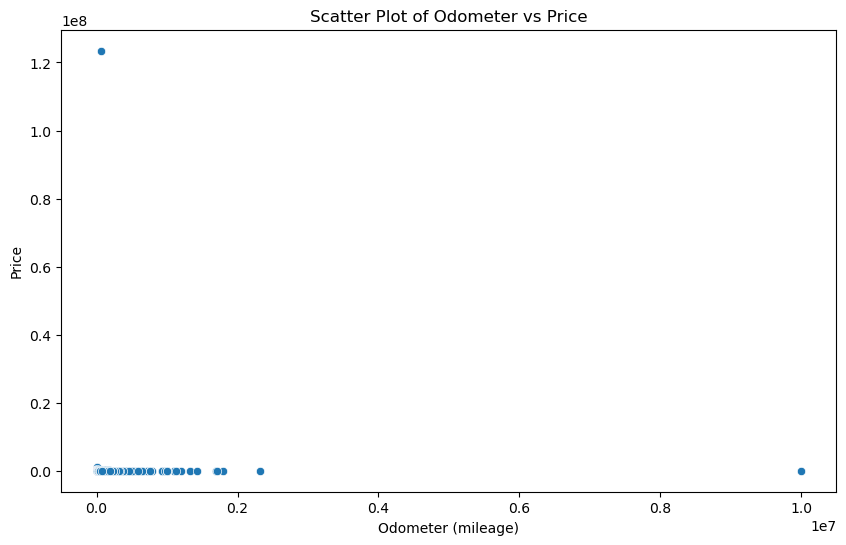

In [20]:
# Plotting odometer vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=vehicles_df['odometer'], y=vehicles_df['price'])

# Add labels and title
plt.xlabel('Odometer (mileage)')
plt.ylabel('Price')
plt.title('Scatter Plot of Odometer vs Price')

# Display the plot
plt.show()

### 2.17 Checking for Outliers using IQR

In [21]:
# Function to detect outliers using IQR
def detect_outliers(df, columns):
    outliers = pd.DataFrame()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Concatenate outliers found in the current column with the outliers DataFrame
        outliers = pd.concat([outliers, df[(df[col] < lower_bound) | (df[col] > upper_bound)]])
    
    # Remove duplicates since some rows might be outliers in more than one column
    outliers = outliers.drop_duplicates()
    
    return outliers

# Identify numerical columns
numeric_cols = vehicles_df.select_dtypes(include=['float64', 'int64']).columns

# Detect outliers
outliers = detect_outliers(vehicles_df, numeric_cols)

# Display the outliers
print(f"Outliers detected:\n{outliers}")


Outliers detected:
            region  price  manufacturer                  model cylinders  \
346     birmingham  98900       ferrari             360 modena         8   
365     birmingham  72900     chevrolet                  tahoe         8   
439     birmingham  48900     chevrolet  silverado 2500 hd ltz         8   
452     birmingham  50990  mercedesbenz                 sclass         8   
803     birmingham  49990          ford    super duty f550 drw         8   
...            ...    ...           ...                    ...       ...   
425713      wausau  10000     chevrolet               corvette         8   
426373     wyoming   7500     chevrolet       scottdale big 10         8   
426376     wyoming   4790     chevrolet              silverado         8   
426604     wyoming  10900        toyota                   rav4         4   
426833     wyoming   6800        jaguar        xk8 convertible         8   

          fuel  odometer title_status transmission drive         typ

### 2.18 Removing Outliers 

In [22]:
# Function to remove outliers using the IQR method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Apply the function to remove outliers
df_cleaned = remove_outliers(vehicles_df, numeric_cols)

# Display the number of rows before and after outlier removal
print(f"Number of rows before outlier removal: {len(vehicles_df)}")
print(f"Number of rows after outlier removal: {len(df_cleaned)}")
print(f"Number of outliers removed: {len(vehicles_df) - len(df_cleaned)}")
vehicles_df = df_cleaned


Number of rows before outlier removal: 53653
Number of rows after outlier removal: 50108
Number of outliers removed: 3545


### 2.19 Check Age, Manufacturer and Odometer again for Outliers

From the new graphs we can now see better distributions

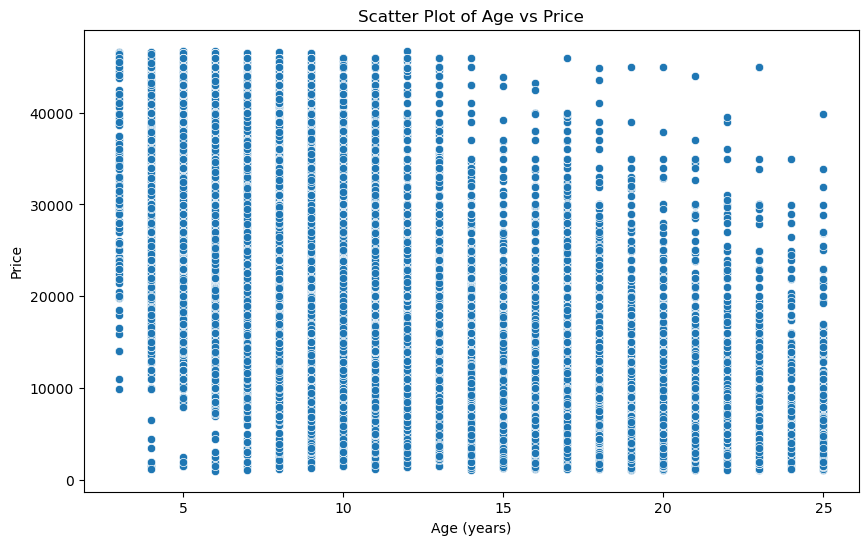

In [23]:
# Plotting Age vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=vehicles_df['age'], y=vehicles_df['price'])

# Add labels and title
plt.xlabel('Age (years)')
plt.ylabel('Price')
plt.title('Scatter Plot of Age vs Price')

# Display the plot
plt.show()

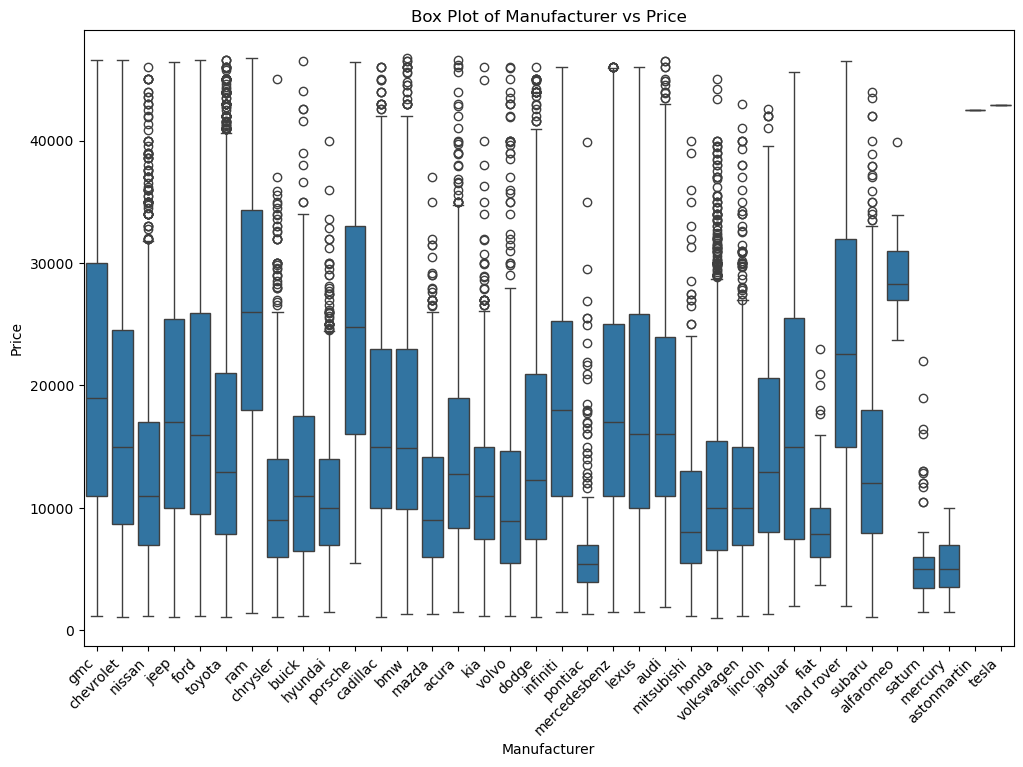

In [24]:
# Plotting Manufacturer vs. Price using a Box Plot
plt.figure(figsize=(12, 8))
sns.boxplot(x=vehicles_df['manufacturer'], y=vehicles_df['price'])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Manufacturer')
plt.ylabel('Price')
plt.title('Box Plot of Manufacturer vs Price')

# Display the plot
plt.show()

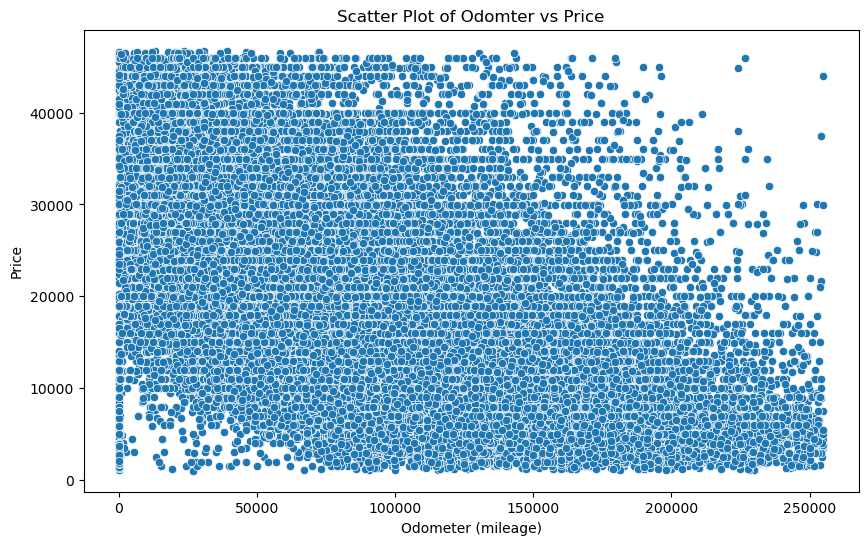

In [25]:
# Plotting odometer vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=vehicles_df['odometer'], y=vehicles_df['price'])

# Add labels and title
plt.xlabel('Odometer (mileage)')
plt.ylabel('Price')
plt.title('Scatter Plot of Odomter vs Price')

# Display the plot
plt.show()

### 2.20 Save to CSV prior to encoding

In [26]:
vehicles_df.to_csv('data/vehicles_final.csv', index=False)

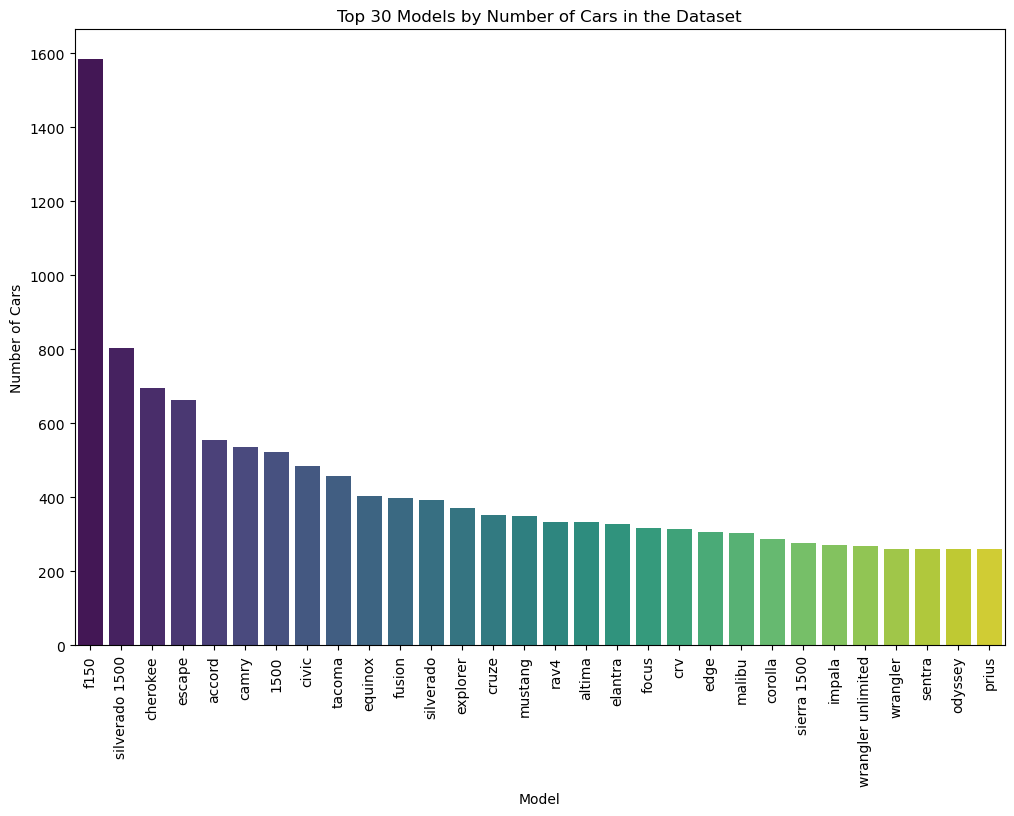

In [27]:
# Count the number of cars for each model
model_counts = vehicles_df['model'].value_counts()

top_n = 30  # Set the number of top models to display
top_model_counts = model_counts.head(top_n)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_model_counts.index, y=top_model_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel('Number of Cars')
plt.title(f'Top {top_n} Models by Number of Cars in the Dataset')
plt.show()


### 2.21 Preprocessing , Encoding data

In [28]:

# Apply One-Hot Encoding to the these categorical columns
vehicles_df = pd.get_dummies(vehicles_df, columns=['manufacturer','transmission','fuel', 'title_status', 'drive', 'type', 'paint_color'])

# Frequency Encoding for 'model'
model_freq = vehicles_df['model'].value_counts().to_dict()
vehicles_df['model'] = vehicles_df['model'].map(model_freq)

# Frequency Encoding for 'region'
region_freq = vehicles_df['region'].value_counts().to_dict()
vehicles_df['region'] = vehicles_df['region'].map(region_freq)

# Frequency Encoding for 'state'
state_freq = vehicles_df['state'].value_counts().to_dict()
vehicles_df['state'] = vehicles_df['state'].map(state_freq)

# Display the first few rows to verify the encoding
vehicles_df = vehicles_df.astype(int)
print(vehicles_df.head())


    region  price  model  cylinders  odometer  state  age  manufacturer_acura  \
32      21  27990      4          8     68696    748   12                   0   
33      21  34590     50          6     29499    748    8                   0   
35      21  29990    173          6     17302    748    8                   0   
42      21  37990     30          8      9704    748    8                   0   
45      21  27990      7          6     37332    748    6                   0   

    manufacturer_alfaromeo  manufacturer_astonmartin  ...  paint_color_brown  \
32                       0                         0  ...                  0   
33                       0                         0  ...                  0   
35                       0                         0  ...                  0   
42                       0                         0  ...                  0   
45                       0                         0  ...                  0   

    paint_color_custom  paint_co

In [29]:
vehicles_df = vehicles_df.astype(int)

In [30]:
vehicles_df_final = vehicles_df

### 2.22 Check for Correlation Between Features

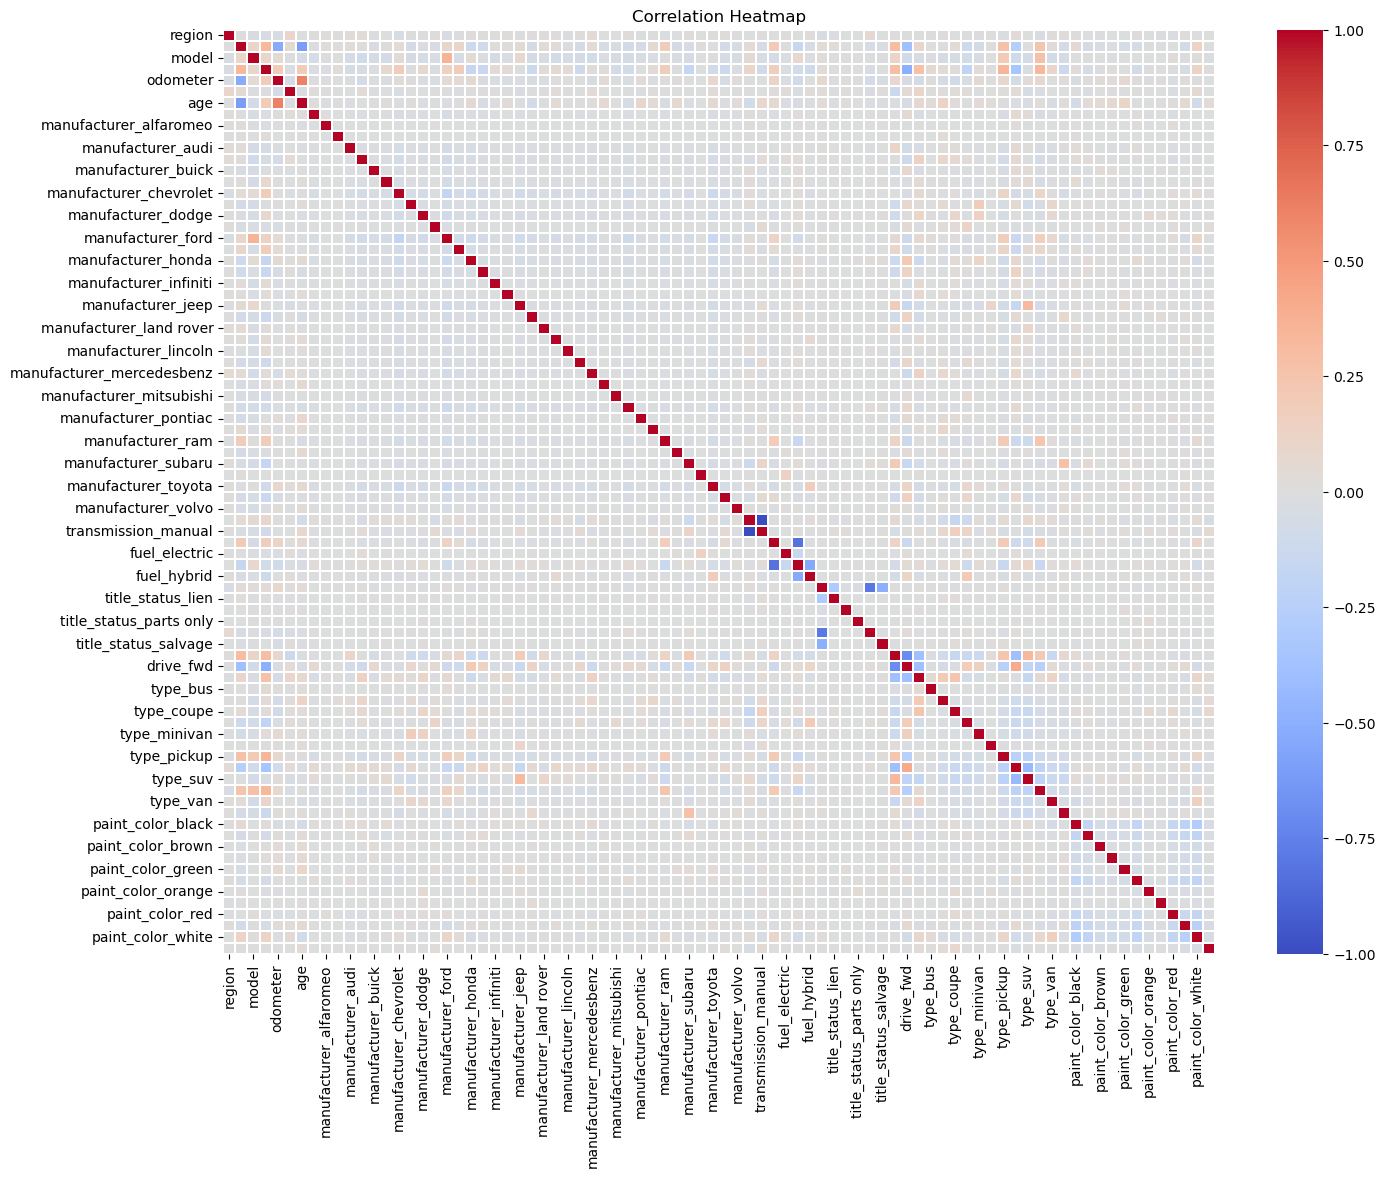

In [31]:
# Calculate the correlation matrix for the numeric columns
correlation_matrix = vehicles_df_final.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.3)
plt.title("Correlation Heatmap")
plt.show()


In [32]:
# Set the threshold for correlation
correlation_threshold = 0.8

# Identify pairs of highly correlated features
high_correlation = np.where(np.abs(correlation_matrix) > correlation_threshold)
high_correlation_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y]) 
                          for x, y in zip(*high_correlation) if x != y]

# Remove duplicates (e.g., (A, B) and (B, A))
high_correlation_pairs = list(set(tuple(sorted(pair)) for pair in high_correlation_pairs))

# Display highly correlated pairs
print("Highly correlated pairs (correlation > 0.8 or < -0.8):")
for pair in high_correlation_pairs:
    print(f"{pair[0]} and {pair[1]}: {correlation_matrix.loc[pair[0], pair[1]]}")


Highly correlated pairs (correlation > 0.8 or < -0.8):
transmission_automatic and transmission_manual: -1.0000000000000004
fuel_diesel and fuel_gas: -0.8214113883792752


### 2.23 Remove Correlated Features

In [33]:
vehicles_df_final = vehicles_df_final.drop(columns=['fuel_diesel'])
vehicles_df_final = vehicles_df_final.drop(columns=['transmission_manual'])

In [34]:
correlation_matrix = vehicles_df_final.corr()

# Set the threshold for correlation
correlation_threshold = 0.8

# Identify pairs of highly correlated features
high_correlation = np.where(np.abs(correlation_matrix) > correlation_threshold)
high_correlation_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y]) 
                          for x, y in zip(*high_correlation) if x != y]

# Remove duplicates (e.g., (A, B) and (B, A))
high_correlation_pairs = list(set(tuple(sorted(pair)) for pair in high_correlation_pairs))

# Display highly correlated pairs
print("Highly correlated pairs (correlation > 0.8 or < -0.8):")
for pair in high_correlation_pairs:
    print(f"{pair[0]} and {pair[1]}: {correlation_matrix.loc[pair[0], pair[1]]}")


Highly correlated pairs (correlation > 0.8 or < -0.8):


### 2.24 Final look at Features before Modeling

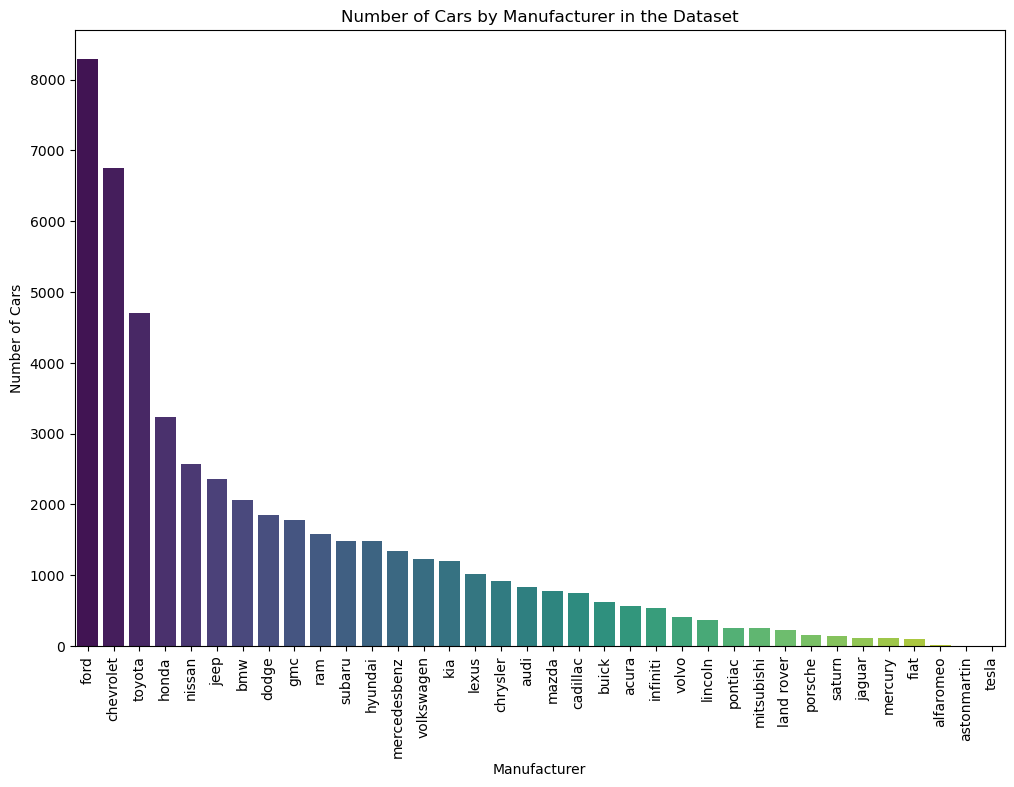

In [35]:

# Identify columns related to manufacturers
manufacturer_columns = [col for col in vehicles_df_final.columns if col.startswith('manufacturer_')]

# Sum the values for each manufacturer
manufacturer_counts = vehicles_df_final[manufacturer_columns].sum().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=manufacturer_counts.index.str.replace('manufacturer_', ''), y=manufacturer_counts.values, palette='viridis')

# Rotate x labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Manufacturer')
plt.ylabel('Number of Cars')
plt.title('Number of Cars by Manufacturer in the Dataset')

# Show plot
plt.show()


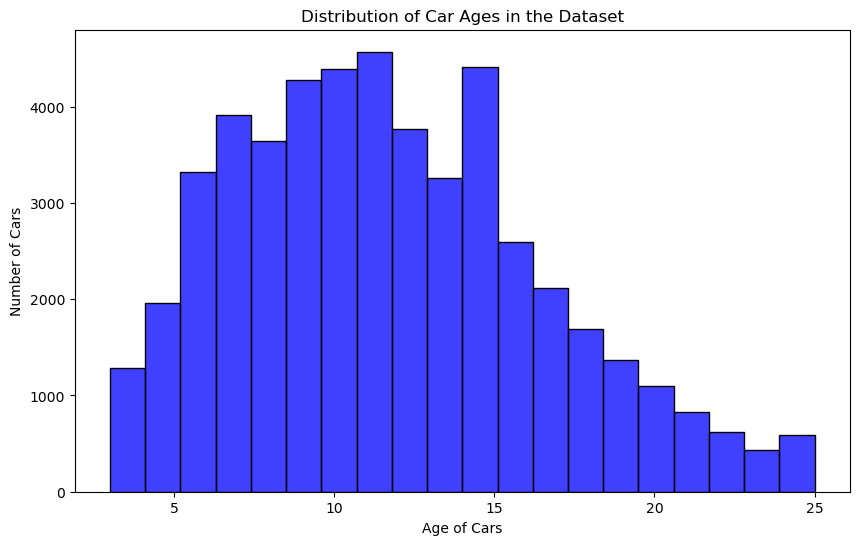

In [36]:
# Create a histogram of the age of cars
plt.figure(figsize=(10, 6))
sns.histplot(vehicles_df_final['age'], bins=20, kde=False, color='blue')

# Add labels and title
plt.xlabel('Age of Cars')
plt.ylabel('Number of Cars')
plt.title('Distribution of Car Ages in the Dataset')

# Show plot
plt.show()

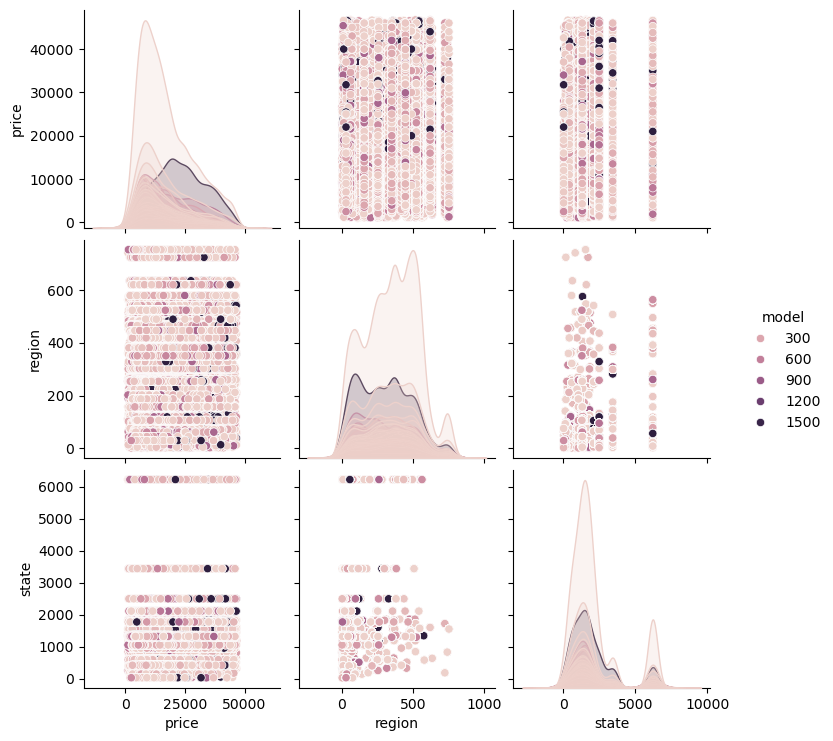

In [37]:
selected_features = [
    'price', 'region', 'state'
]

# Create the pair plot with 'model' as the hue
sns.pairplot(vehicles_df, vars=selected_features, hue='model', diag_kind='kde', height=2.5)
plt.show()


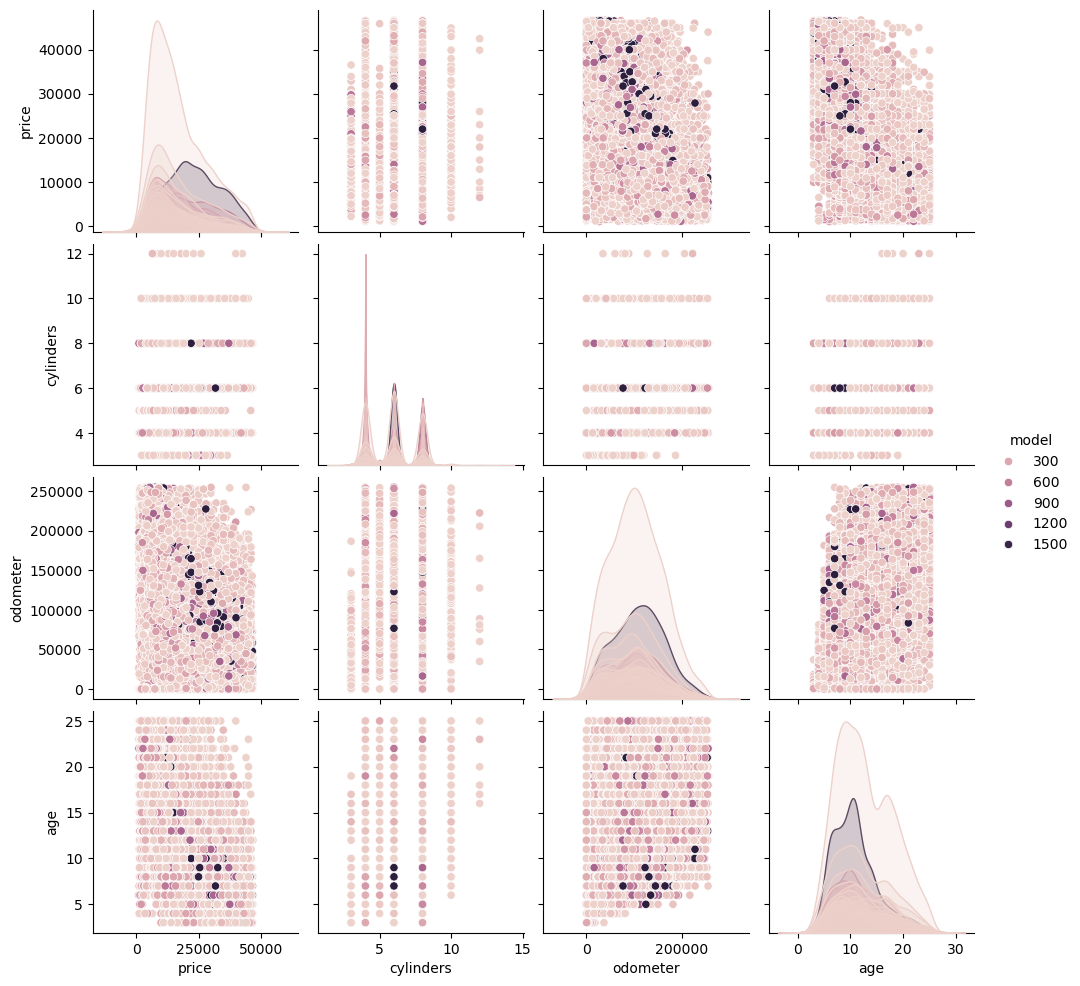

In [38]:
selected_features = [
    'price', 'cylinders', 'odometer', 'age'
]

# Create the pair plot with 'model' as the hue
sns.pairplot(vehicles_df, vars=selected_features, hue='model', diag_kind='kde', height=2.5)
plt.show()

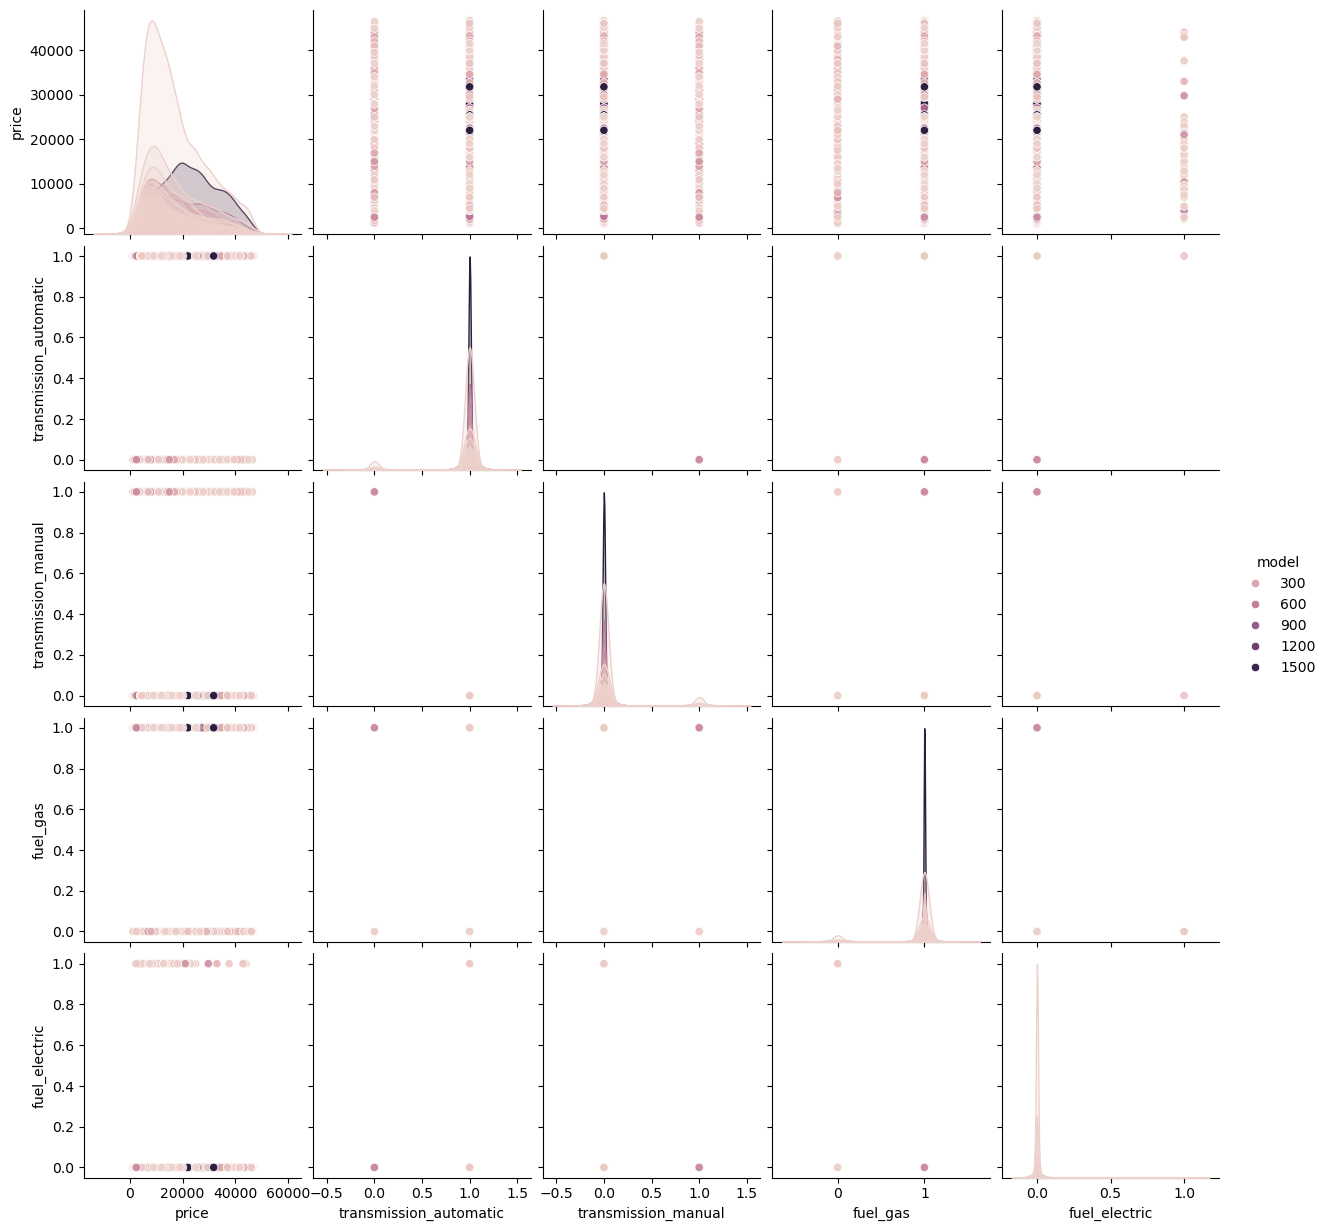

In [39]:
selected_features = [
    'price', 'transmission_automatic', 'transmission_manual', 'fuel_gas', 'fuel_electric'
]

# Create the pair plot with 'model' as the hue
sns.pairplot(vehicles_df, vars=selected_features, hue='model', diag_kind='kde', height=2.5)
plt.show()

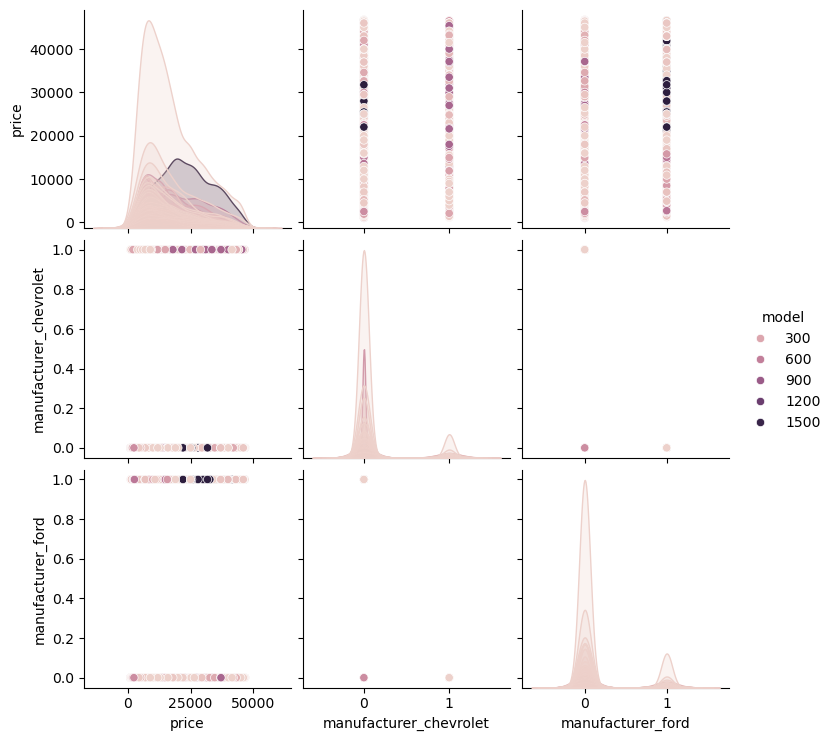

In [40]:
selected_features = [
    'price', 'manufacturer_chevrolet','manufacturer_ford'
]

# Create the pair plot with 'model' as the hue
sns.pairplot(vehicles_df, vars=selected_features, hue='model', diag_kind='kde', height=2.5)
plt.show()

## 3 Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### 3.1 Feature Selection and Transformation
This code prepares data for regression by performing the following steps:

    Feature Selection: Uses forward feature selection to choose the best features from the training data.
    Data Splitting: Separates data into training and testing sets.
    Log Transformation: Applies log transformation to skewed numerical features to normalize them.
    Feature Scaling: Standardizes numerical features for consistent scaling.
    Target Transformation: Log-transforms the target variable (price) to handle skewness.

This process sets up the data for efficient and accurate modeling.

In [41]:
# Forward Feature Selection
def forward_feature_selection(X_train, y_train_log, model):
    sfs = SequentialFeatureSelector(model, direction='forward', n_features_to_select='auto', cv=5)
    sfs.fit(X_train, y_train_log)
    return sfs.get_support()

# Assuming 'price' is the target variable
df = vehicles_df_final
X = df.drop('price', axis=1)
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numerical columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Apply log transformation to skewed numerical features
X_train[numeric_cols] = X_train[numeric_cols].apply(lambda x: np.log1p(x) if np.abs(x.skew()) > 0.5 else x)
X_test[numeric_cols] = X_test[numeric_cols].apply(lambda x: np.log1p(x) if np.abs(x.skew()) > 0.5 else x)

# Scale the features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Log transform the target variable
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

### 3.2 Regression Selection and Hyperparameter Settings

This code defines a set of regression models and their respective hyperparameter grids for tuning:

    Models:
        Linear Regression: Basic linear regression without hyperparameters.
        Ridge Regression: Linear regression with L2 regularization.
        Lasso Regression: Linear regression with L1 regularization.
        ElasticNet Regression: Combination of L1 (Lasso) and L2 (Ridge) regularization.

    Parameter Grids:
        Ridge and Lasso: The key hyperparameter for both is alpha, which controls the strength of regularization.
        ElasticNet: In addition to alpha, it includes l1_ratio, which balances between L1 and L2 regularization.

These models and parameter grids are used for hyperparameter tuning, likely with techniques such as GridSearchCV

In [42]:
# Define models and parameter grids
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet()
}

param_grids = {
    'Ridge Regression': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
    'Lasso Regression': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
    'ElasticNet Regression': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'l1_ratio': [0.1, 0.5, 0.9]
    }
}

### 3.3 Model Training

This code performs model training with feature selection and stores key results for evaluation:

    Setup: Initializes results to store metrics and selected_features_dict to store selected features for each model.

    Model Training:
        Feature Selection: For each model (Linear, Ridge, Lasso, ElasticNet), forward feature selection identifies important features.
        Selected and Dropped Features: The relevant and irrelevant features are printed and stored.
        Training:
            Linear Regression is directly trained.
            For Ridge, Lasso, and ElasticNet, GridSearchCV is used for hyperparameter tuning and the best model is selected.

    Evaluation:
        Predictions are made, and MSE and R-squared are calculated.
        The results (including coefficients and hyperparameters) are stored for each model.

This process ensures feature selection and tuning, enabling accurate model evaluation.

In [43]:

# Results storage and feature storage
results = {}
selected_features_dict = {}  # To store the selected features for each model

# Train models, perform feature selection and hyperparameter tuning
for name, model in models.items():
    # Apply forward feature selection
    selected_features_mask = forward_feature_selection(X_train, y_train_log, model)
    
    # Get the column names of selected and dropped features
    selected_features = X_train.columns[selected_features_mask]
    dropped_features = X_train.columns[~selected_features_mask]
    
    # Store the selected features for each model
    selected_features_dict[name] = selected_features
    
    # Print selected and dropped features for each model
    print(f"\nModel: {name}")
    print("Selected Features:")
    print(selected_features)
    print("Dropped Features:")
    print(dropped_features)
    
    # Select columns based on forward selection mask
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]  # Apply the same feature selection to test set
    
    if name == 'Linear Regression':
        # Linear regression has no hyperparameters, so just fit and evaluate
        model.fit(X_train_selected, y_train_log)
        y_pred_log = model.predict(X_test_selected)
    else:
        # Use GridSearchCV for Ridge, Lasso, and ElasticNet
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', n_jobs=-1)
        grid.fit(X_train_selected, y_train_log)
        model = grid.best_estimator_
        y_pred_log = model.predict(X_test_selected)
    
    y_pred = np.expm1(y_pred_log)  # Reverse log transformation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    coefficients_dict = dict(zip(selected_features, model.coef_))
    if name == 'Linear Regression':
        results[name] = {'MSE': mse, 'R-squared': r2, 'Coefficients': coefficients_dict}
    else:
        results[name] = {
            'Best Params': grid.best_params_,
            'MSE': mse,
            'R-squared': r2,
            'Coefficients': coefficients_dict
        }


Model: Linear Regression
Selected Features:
Index(['cylinders', 'odometer', 'state', 'age', 'manufacturer_acura',
       'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_cadillac',
       'manufacturer_chrysler', 'manufacturer_dodge', 'manufacturer_fiat',
       'manufacturer_honda', 'manufacturer_infiniti', 'manufacturer_jeep',
       'manufacturer_land rover', 'manufacturer_lexus',
       'manufacturer_mercedesbenz', 'manufacturer_mercury',
       'manufacturer_mitsubishi', 'manufacturer_nissan',
       'manufacturer_porsche', 'manufacturer_saturn', 'manufacturer_toyota',
       'transmission_automatic', 'fuel_electric', 'fuel_gas', 'fuel_hybrid',
       'title_status_clean', 'title_status_lien', 'title_status_salvage',
       'drive_4wd', 'drive_fwd', 'type_convertible', 'type_coupe',
       'type_hatchback', 'type_pickup', 'type_sedan', 'type_truck',
       'paint_color_silver'],
      dtype='object')
Dropped Features:
Index(['region', 'model', 'manufacturer_alfaromeo', 'man

## 4 Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this. We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices. Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [44]:

# Display the results
results_df = pd.DataFrame(results).T
print(results_df)


                                   MSE R-squared  \
Linear Regression      31038500.248339  0.697659   
Ridge Regression       31022261.575608  0.697817   
Lasso Regression       39148060.980347  0.618665   
ElasticNet Regression  39743127.278168  0.612868   

                                                            Coefficients  \
Linear Regression      {'cylinders': 0.16962216275629707, 'odometer':...   
Ridge Regression       {'cylinders': 0.16954466308968447, 'odometer':...   
Lasso Regression       {'region': 0.0, 'model': 0.0, 'cylinders': 0.2...   
ElasticNet Regression  {'region': 0.005408287687512938, 'model': 0.0,...   

                                            Best Params  
Linear Regression                                   NaN  
Ridge Regression                        {'alpha': 10.0}  
Lasso Regression                        {'alpha': 0.01}  
ElasticNet Regression  {'alpha': 0.01, 'l1_ratio': 0.1}  


### 4.1 Predictions for each Model

This code performs predictions for each model after feature selection and outputs the predicted prices for the first 5 entries in the test dataset (X_test). Here's a step-by-step summary of the process:

    Retrieve Selected Features:
        For each model (Linear Regression, Ridge, Lasso, ElasticNet), it retrieves the selected features stored in selected_features_dict during training.
        These features are used to create a subset of the test data (X_test_selected).

    Prediction for Linear Regression:
        For Linear Regression, the model is directly used to predict the target prices for the selected test features.

    Prediction for Other Models:
        For Ridge, Lasso, and ElasticNet, GridSearchCV is re-run to find the best model with the selected features and then used for prediction.

    Log Transformation:
        The predictions (y_pred_example) are in log scale, so the script reverses the log transformation using np.expm1() to bring the predictions back to the original price scale.

    Output:
        The converted original scale predictions for the first 5 test entries are printed for each model.

This approach ensures that all models make predictions using the same selected features, while also performing hyperparameter tuning for non-linear regression models.


In [45]:

# Example Prediction for each model
for name, model in models.items():
    selected_features = selected_features_dict[name]  # Ensure we are using the same features
    X_test_selected = X_test[selected_features]  # Use the correct test features
    
    if name == 'Linear Regression':
        y_pred_example = model.predict(X_test_selected[:5])
    else:
        # For other models, use the best estimator from GridSearchCV
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', n_jobs=-1)
        grid.fit(X_train[selected_features], y_train_log)  # Fit using selected features
        best_model = grid.best_estimator_
        y_pred_example = best_model.predict(X_test_selected[:5])
    
    y_pred_example_original = np.expm1(y_pred_example)  # Convert back to original price scale
    print(f"Example predictions for {name} (Original Scale):", y_pred_example_original)


Example predictions for Linear Regression (Original Scale): [14266.76796144 13078.17038563  7049.36294359 10048.0640286
 44140.28223909]
Example predictions for Ridge Regression (Original Scale): [14267.44496095 13078.57104761  7050.26478149 10047.92106561
 44127.42252622]
Example predictions for Lasso Regression (Original Scale): [11010.37530992 14254.34641802  9635.5412531  10931.34305075
 52338.91185737]
Example predictions for ElasticNet Regression (Original Scale): [11676.55495312 14729.80876891  9786.39995681 11667.28443075
 51873.72062992]


In [46]:
results_df

,MSE,R-squared,Coefficients,Best Params
Linear Regression,31038500.248339,0.697659,"{'cylinders': 0.16962216275629707, 'odometer':...",NaN
Ridge Regression,31022261.575608,0.697817,"{'cylinders': 0.16954466308968447, 'odometer':...",{'alpha': 10.0}
Lasso Regression,39148060.980347,0.618665,"{'region': 0.0, 'model': 0.0, 'cylinders': 0.2...",{'alpha': 0.01}
ElasticNet Regression,39743127.278168,0.612868,"{'region': 0.005408287687512938, 'model': 0.0,...","{'alpha': 0.01, 'l1_ratio': 0.1}"


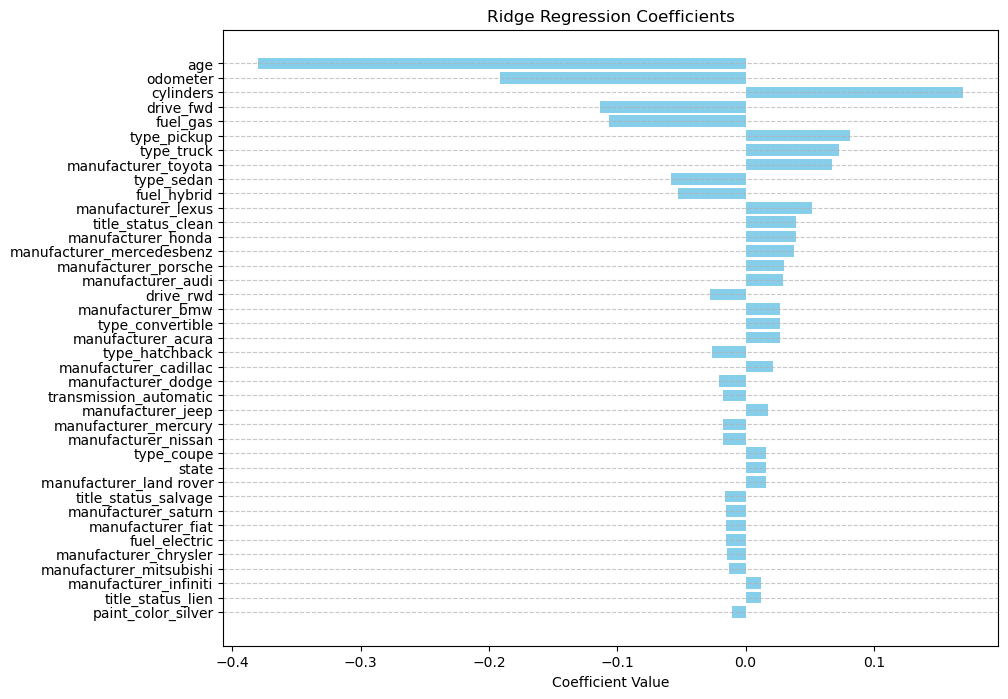

In [47]:

# Extract the Ridge Regression coefficients from the results DataFrame
ridge_coefficients_dict = results_df.loc['Ridge Regression', 'Coefficients']

# Convert the dictionary into a DataFrame for easier plotting
ridge_coefficients_df = pd.DataFrame(list(ridge_coefficients_dict.items()), columns=['Feature', 'Coefficient'])

# Sort by absolute value of coefficients for better visualization
ridge_coefficients_df['abs_coefficient'] = ridge_coefficients_df['Coefficient'].abs()
ridge_coefficients_df = ridge_coefficients_df.sort_values(by='abs_coefficient', ascending=False)

# Plot the coefficients with horizontal grid
plt.figure(figsize=(10, 8))
plt.barh(ridge_coefficients_df['Feature'], ridge_coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Ridge Regression Coefficients')

# Adding horizontal grid lines
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Adds gridlines on the y-axis

# Invert y-axis to show the largest coefficients on top
plt.gca().invert_yaxis()
plt.show()




In [48]:
ridge_coefficients_df

,Feature,Coefficient,abs_coefficient
3,age,-0.379703,0.379703
1,odometer,-0.191208,0.191208
0,cylinders,0.169545,0.169545
30,drive_fwd,-0.113679,0.113679
25,fuel_gas,-0.106532,0.106532
35,type_pickup,0.081526,0.081526
37,type_truck,0.072925,0.072925
22,manufacturer_toyota,0.067649,0.067649
36,type_sedan,-0.057811,0.057811
26,fuel_hybrid,-0.052973,0.052973


## 5 Deployment¶

Now that we've settled on our models and findings, it is time to deliver the information to the client. You should organize your work as a basic report that details your primary findings. Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Thank you for the opportunity to present insights from our recent analysis, which focuses on identifying the key factors that impact the pricing of used vehicles. Our goal is to help you fine-tune your inventory by providing data-driven guidance on what kinds of cars tend to command higher prices, and which ones might be less valuable in the market.

# 1 Cars That Command Higher Prices:

## 1.1 Cars with More Cylinders: 
Vehicles with more cylinders generally demand higher prices. These are typically associated with larger, more powerful engines, such as trucks and high-performance vehicles.
### Actionable Insight: 
Consider stocking cars with higher cylinder counts (6-cylinder or 8-cylinder engines), such as trucks, SUVs, or performance sedans, as they tend to retain their value better.

## 1.2 Pickup Trucks & Trucks: 
Both pickup trucks and trucks showed positive impacts on price. These vehicles are popular for their utility and robustness, making them in demand, especially for work or recreational purposes.
### Actionable Insight: 
Adding more pickups and trucks to your inventory can attract buyers willing to pay a premium for these versatile vehicles.

## 1.3 Certain Manufacturers: 
Brands like Toyota, Lexus, Mercedes-Benz, Porsche, and Honda hold their value well. Buyers associate these brands with reliability, luxury, and performance, contributing to higher resale prices.
### Actionable Insight: 
Focus on acquiring well-maintained vehicles from these manufacturers. Their strong brand reputation and desirability in the used market can fetch higher prices.

## 1.4 Luxury Models and Convertibles: 
Specialty cars like convertibles and models from high-end manufacturers (e.g., Porsche, Lexus) also command a premium.
### Actionable Insight: 
Niche luxury vehicles that are well-maintained can be a worthwhile investment for your inventory, as they attract buyers looking for status or unique driving experiences.

# 2 Cars to Be Cautious Of (Lower Prices):

## 2.1 Older Vehicles:
Age is the single biggest factor in reducing car prices. As a vehicle gets older, its value drops considerably.
### Actionable Insight: 
Avoid stocking cars that are significantly older, especially if they lack unique qualities like low mileage or exceptional maintenance records.

## 2.2 High Mileage Vehicles (Odometer): 
Cars with higher odometer readings also see a reduction in price. Mileage is a clear signal of wear and tear, so high-mileage vehicles tend to be less appealing to buyers.
### Actionable Insight: 
Focus on acquiring vehicles with lower mileage, even if they are slightly older. Buyers are often willing to pay more for vehicles that have less wear.

## 2.3 Gasoline & Hybrid Vehicles:
While hybrid cars offer better fuel economy, they didn’t perform as well in terms of retaining value, similar to gasoline-powered vehicles. This could be due to the availability of newer models with better technology.
### Actionable Insight: 
Be selective with hybrids and gas vehicles, and avoid those that are outdated or have less demand. Electric vehicles may be a more future-proof option, especially as interest in greener cars grows.

## 2.4 Sedans and Hatchbacks: 
These types of vehicles typically saw a lower price in our analysis. Sedans and hatchbacks are widely available, leading to more competition and lower resale values.
### Actionable Insight: 
While sedans and hatchbacks remain popular, it’s important to focus on models with low mileage, high reliability, or those from high-demand manufacturers. Avoid flooding your inventory with too many sedans that don’t have standout features.

# 3 Final Recommendations:

### 3.1 High-Priced Focus: 
Concentrate on acquiring trucks, pickups, and luxury vehicles, especially from brands like Toyota, Lexus, Mercedes-Benz, and Porsche.
### 3.2 Avoid Low-Value Vehicles: 
Stay away from vehicles with high mileage or that are significantly older unless they come from a highly desirable manufacturer or are in exceptional condition.
### 3.3 Monitor Trends: 
While gasoline and hybrid cars might not fetch the highest prices now, keep an eye on the market as preferences shift towards electric and more fuel-efficient models.

By focusing on these insights, you can optimize your inventory to include vehicles that will demand higher prices, reduce the risk of holding lower-value cars, and ultimately improve profitability.